In [ ]:
# import modules
## computer vision
import cv2
## keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model, load_model
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

##sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## display images
from IPython.display import Image

## matplotlib
from matplotlib import pyplot as plt

## others
import pandas as pd
import numpy as np
import os

In [ ]:
# mount drive to upload data
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# folder path
train_path = '/content/drive/My Drive/Fire_Detect_DL/train'
val_path = '/content/drive/My Drive/Fire_Detect_DL/val'
test_path = '/content/drive/My Drive/Fire_Detect_DL/test'

In [ ]:
# load dataset from google drive
dir_path = os.listdir(train_path)
num_labels = [i for i in range(len(dir_path))]
label_dict = dict(zip(dir_path, num_labels))

In [ ]:
label_dict, num_labels

({'fire_images': 0, 'non_fire_images': 1}, [0, 1])

In [ ]:
# Generate batches of tensor image data
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(train_path, target_size=(224,224), batch_size=64)
val_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(val_path, target_size=(224,224), batch_size=32)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(test_path, target_size=(224,224), batch_size=24)

Found 819 images belonging to 2 classes.
Found 222 images belonging to 2 classes.
Found 142 images belonging to 2 classes.


In [ ]:
# Modify mobilenet model
# MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications
mobile = keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 3s 0us/step


In [ ]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [ ]:
# deleting last 5 layers and replacing dense softmax layer of 2 nodes
del_layers_model = mobile.layers[-6].output
predictions = Dense(2, activation='softmax')(del_layers_model)
model = Model(inputs=mobile.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [ ]:
# freezing weights all the layers upto the 4th last layer
# this is done because we will re-train only the last three layers
for layer in model.layers[:-4]:
  layer.trainable = False

In [ ]:
# Model training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpointer = ModelCheckpoint(filepath = '/content/drive/My Drive/Fire_Detect_DL/model-{epoch:03d}.model', 
                               monitor='val_loss', verbose=1, save_best_only=True, 
                               save_weights_only=False, mode='auto', period=1)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=0.00001)

In [ ]:
model.fit_generator(train_batches, steps_per_epoch=38, validation_data=val_batches,
                    validation_steps=38, epochs=10, verbose=1, callbacks=[checkpointer,reduce_lr])

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 1 could not be retrieved. It could be because a worker has died.
  UserWarning)


 2/38 [>.............................] - ETA: 22:21 - loss: 1.1416 - accuracy: 0.3594

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)


 3/38 [=>............................] - ETA: 21:32 - loss: 1.1466 - accuracy: 0.3490

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 11 could not be retrieved. It could be because a worker has died.
  UserWarning)


 4/38 [==>...........................] - ETA: 20:41 - loss: 1.0960 - accuracy: 0.3828

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 2 could not be retrieved. It could be because a worker has died.
  UserWarning)


 5/38 [==>...........................] - ETA: 20:09 - loss: 1.0651 - accuracy: 0.4125

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 3 could not be retrieved. It could be because a worker has died.
  UserWarning)


 6/38 [===>..........................] - ETA: 19:31 - loss: 1.0247 - accuracy: 0.4375

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 5 could not be retrieved. It could be because a worker has died.
  UserWarning)


 7/38 [====>.........................] - ETA: 19:20 - loss: 0.9646 - accuracy: 0.4754

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 9 could not be retrieved. It could be because a worker has died.
  UserWarning)


 8/38 [=====>........................] - ETA: 18:41 - loss: 0.9268 - accuracy: 0.4922

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 8 could not be retrieved. It could be because a worker has died.
  UserWarning)


 9/38 [======>.......................] - ETA: 17:54 - loss: 0.8841 - accuracy: 0.5156

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 7 could not be retrieved. It could be because a worker has died.
  UserWarning)


10/38 [======>.......................] - ETA: 17:10 - loss: 0.8548 - accuracy: 0.5375

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 10 could not be retrieved. It could be because a worker has died.
  UserWarning)


12/38 [========>.....................] - ETA: 15:27 - loss: 0.7958 - accuracy: 0.5682

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 6 could not be retrieved. It could be because a worker has died.
  UserWarning)


38/38 [==============================] - 531s 14s/step - loss: 0.4553 - accuracy: 0.7743 - val_loss: 1.1900 - val_accuracy: 0.5149

Epoch 00001: val_loss improved from inf to 1.19004, saving model to /content/drive/My Drive/Fire_Detect_DL/model-001.model
Epoch 2/10
38/38 [==============================] - 87s 2s/step - loss: 0.1609 - accuracy: 0.9427 - val_loss: 1.0980 - val_accuracy: 0.5174

Epoch 00002: val_loss improved from 1.19004 to 1.09803, saving model to /content/drive/My Drive/Fire_Detect_DL/model-002.model
Epoch 3/10
38/38 [==============================] - 92s 2s/step - loss: 0.1067 - accuracy: 0.9653 - val_loss: 1.0347 - val_accuracy: 0.5440

Epoch 00003: val_loss improved from 1.09803 to 1.03465, saving model to /content/drive/My Drive/Fire_Detect_DL/model-003.model
Epoch 4/10
38/38 [==============================] - 87s 2s/step - loss: 0.0826 - accuracy: 0.9751 - val_loss: 1.0691 - val_accuracy: 0.5282

Epoch 00004: val_loss did not improve from 1.03465
Epoch 5/10
38/38 

In [ ]:
# test model
test_labels = test_batches.classes
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
test_labels.shape

(142,)

In [ ]:
# predictions
predictions = model.predict(test_batches, steps=47, verbose=1)

47/47 [==============================] - 56s 1s/step


**Predictions**

In [ ]:
# model path
model_path = '/content/drive/My Drive/Fire_Detect_DL/model-009.model' 

In [ ]:
# load model
fire_model = keras.models.load_model(model_path)

In [ ]:
# function for preparing imgages
def image_prep(file):
  img_path = ''
  img = image.load_img(img_path + file, target_size=(224,224))
  img_arr = image.img_to_array(img)
  img_array_expanded_dims = np.expand_dims(img_arr, axis=0)
  return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

**1. Fire Images**

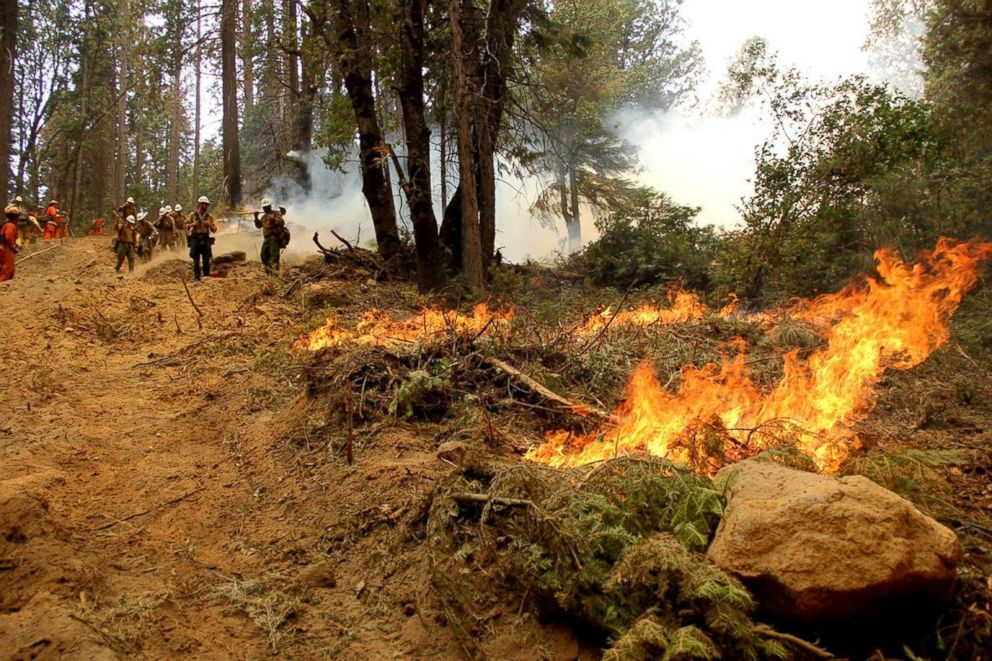

In [ ]:
#show images
fire_image_dir = '/content/drive/My Drive/Fire_Detect_DL/test/fire_images/'
image_name = 'fire.321.png'
Image(filename=fire_image_dir+image_name, width=300,height=200)

In [ ]:
# preprocess image
file_name = fire_image_dir + image_name
image_preparation = image_prep(file_name)
predict_img = fire_model.predict(image_preparation)
print("Fire:", str(predict_img[0][0]*100)[:4] + "%", "Not Fire:", str(predict_img[0][1]*100)[:4]+"%")
labels = (predict_img>0.5).astype(np.int)
print(labels)
if labels[0][0]==1:
  print('Fire Detected')
else: 
  print('No Fire Detected')

Fire: 99.8% Not Fire: 0.15%
[[1 0]]
Fire Detected


In [ ]:
predict_img

array([[0.9984555 , 0.00154449]], dtype=float32)

**2. Non Fire Images**

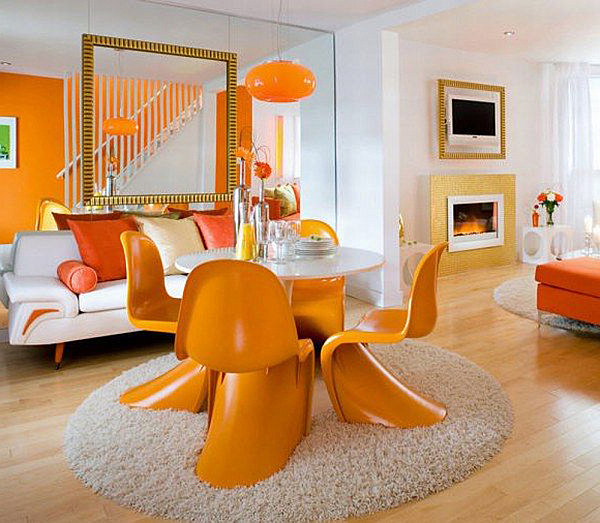

In [ ]:
## non fire image
#show images
fire_image_dir = '/content/drive/My Drive/Fire_Detect_DL/test/non_fire_images/'
image_name = '535.jpg'
Image(filename=fire_image_dir+image_name, width=300,height=200)

In [ ]:
# preprocess image
file_name = fire_image_dir + image_name
image_preparation = image_prep(file_name)
predict_img = fire_model.predict(image_preparation)
print("Fire:", str(predict_img[0][0]*100)[:4] + "%", "Not Fire:", str(predict_img[0][1]*100)[:4]+"%")
labels = (predict_img>0.5).astype(np.int)
print(labels)
if labels[0][0]==1:
  print('Fire Detected')
else: 
  print('No Fire Detected')

Fire: 2.52% Not Fire: 97.4%
[[0 1]]
No Fire Detected


In [ ]:
predict_img

array([[0.02524316, 0.97475684]], dtype=float32)